In [22]:
#Funkcja modelująca rozkład temperatury w 1D 
import numpy as np
def solve_temperature_1D(T_left, T_right, N=50, kal=237.0, kw=0.12, tolerance=0.01):
    """
    Rozwiązuje jednowymiarowy, stacjonarny problem przewodnictwa ciepła
    dla niejednorodnego pręta z dwoma różnymi materiałami.

    Parametry:
    - T_left: temperatura na lewym brzegu pręta
    - T_right: temperatura na prawym brzegu pręta
    - N: liczba węzłów w siatce
    - kal: współczynnik przewodnictwa cieplnego (aluminium)
    - kw: współczynnik przewodnictwa cieplnego (drewno)
    - tolerance: kryterium zbieżności iteracji

    Zwraca:
    - T: rozkład temperatury w pręcie
    """
    dx = 1.0 / (N - 1)

    # Inicjalizacja temperatury
    T = np.zeros(N)
    T[0] = T_left
    T[-1] = T_right

    # Inicjalizacja współczynników przewodnictwa cieplnego
    k = np.ones(N) * kal
    k[N//2:] = kw  # Połowa pręta z drewna

    # Iteracyjne rozwiązywanie równania różnicowego
    for _ in range(10000):
        T_old = T.copy()
        for i in range(1, N - 1):
            T[i] = (k[i-1] * T_old[i-1] + k[i] * T_old[i+1]) / (k[i-1] + k[i])

        # Kryterium zbieżności
        if np.linalg.norm(T - T_old, np.inf) < tolerance:
            break

    return T



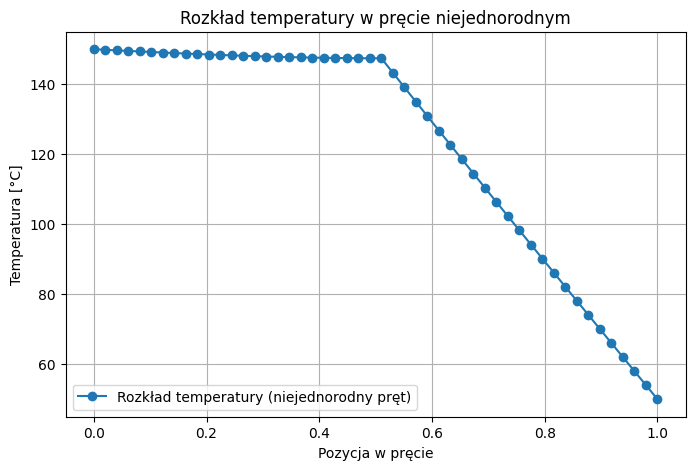

In [ ]:
#Test
import matplotlib.pyplot as plt

# Parametry testowe
N = 50
T0 = 150     # Temperatura na lewym brzegu
TN = 50      # Temperatura na prawym brzegu
kal = 237.0  # Przewodność cieplna aluminium
kw = 0.12    # Przewodność cieplna drewna

# Testowanie funkcji z uwzględnieniem niejednorodności
T_test = solve_temperature_1D(T0, TN, N, kal, kw)

# Wizualizacja wyników
plt.figure(figsize=(8, 5))
plt.plot(np.linspace(0, 1, N), T_test, '-o', label='Rozkład temperatury (niejednorodny pręt)')
plt.title('Rozkład temperatury w pręcie niejednorodnym')
plt.xlabel('Pozycja w pręcie')
plt.ylabel('Temperatura [°C]')
plt.grid(True)
plt.legend()
plt.show()


In [25]:
#Funkcja kosztu
def cost_function_1D(boundary_conditions, T_target, N=50, kal=237.0, kw=0.12):
    """
    Funkcja kosztu dla modelu 1D - mierzy różnicę między obliczonym a docelowym rozkładem temperatury.

    Parametry:
    - boundary_conditions: lista [T_left, T_right] - warunki brzegowe
    - T_target: docelowy rozkład temperatury
    - N: liczba węzłów w siatce
    - kal: współczynnik przewodnictwa cieplnego (aluminium)
    - kw: współczynnik przewodnictwa cieplnego (drewno)

    Zwraca:
    - Wartość funkcji kosztu (norma L2)
    """
    T_left, T_right = boundary_conditions
    T_model = solve_temperature_1D(T_left, T_right, N, kal, kw)
    
    # Norma L2 (średniokwadratowy błąd)
    return np.linalg.norm(T_model - T_target, 2)


In [26]:
#Testowanie funkcji kosztu
# Generowanie docelowego rozkładu temperatury (poprawne warunki brzegowe)
T_target = solve_temperature_1D(T0, TN, N, kal, kw)

# Test funkcji kosztu
test_conditions = [140, 60]  # Przykładowe warunki brzegowe (nieoptymalne)
cost_value = cost_function_1D(test_conditions, T_target, N, kal, kw)

print(f"Wartość funkcji kosztu dla warunków {test_conditions}: {cost_value:.4f}")



Wartość funkcji kosztu dla warunków [140, 60]: 58.2880


Implementacja metody BFGS

In [27]:
from scipy.optimize import minimize

def optimize_bfgs_1D(T_target, N=50, kal=237.0, kw=0.12):
    """
    Optymalizacja warunków brzegowych za pomocą metody BFGS dla modelu 1D.

    Parametry:
    - T_target: docelowy rozkład temperatury
    - N: liczba węzłów w siatce
    - kal: współczynnik przewodnictwa cieplnego (aluminium)
    - kw: współczynnik przewodnictwa cieplnego (drewno)

    Zwraca:
    - Wynik optymalizacji (optymalne warunki brzegowe)
    """
    # Inicjalne zgadywanie warunków brzegowych
    initial_guess = [100, 100]

    # Minimalizacja funkcji kosztu metodą BFGS
    result = minimize(cost_function_1D, 
                      initial_guess, 
                      args=(T_target, N, kal, kw), 
                      method='BFGS', 
                      options={'disp': True})
    
    return result.x  # Zwróć optymalne warunki brzegowe


c:\Users\msigm\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minimize.py:733: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.000000
         Iterations: 33
         Function evaluations: 320
         Gradient evaluations: 103
Optymalne warunki brzegowe (BFGS): [150.  50.]
Czas działania metody BFGS: 95.3542 s


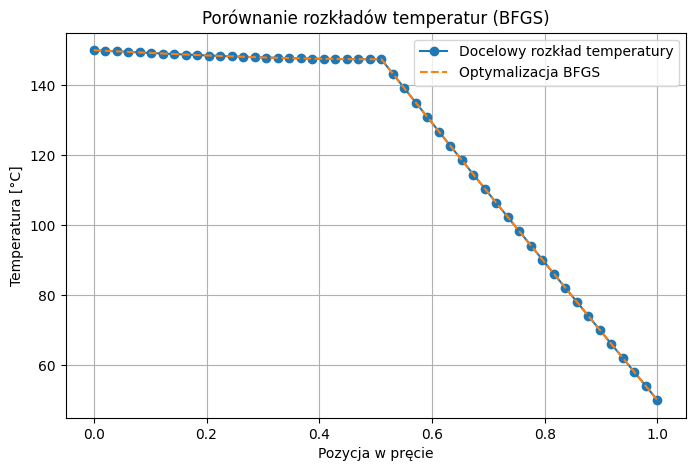


--- Podsumowanie wyników ---
Parametry testowe:
- Liczba węzłów (N): 50
- Przewodność cieplna aluminium (kal): 237.0
- Przewodność cieplna drewna (kw): 0.12
- Temperatura na lewym brzegu (T0): 150
- Temperatura na prawym brzegu (TN): 50
- Tolerancja: 0.01
- Maksymalna liczba iteracji: 10000

Uzyskane warunki brzegowe:
  T_left = 150.0000
  T_right = 50.0000
Czas trwania obliczeń: 95.3542 s


In [28]:
import time

# Parametry testowe
N = 50
kal = 237.0  # Przewodność cieplna aluminium
kw = 0.12    # Przewodność cieplna drewna
T0 = 150      # Temperatura na lewym brzegu
TN = 50       # Temperatura na prawym brzegu
tolerance = 0.01
max_iter = 10000

# Generowanie docelowego rozkładu temperatury (z uwzględnieniem kal i kw)
T_target = solve_temperature_1D(T0, TN, N, kal, kw)

# Pomiar czasu działania metody BFGS
start_time = time.time()
optimal_conditions_bfgs = optimize_bfgs_1D(T_target, N, kal, kw)
end_time = time.time()

# Wyniki
print(f"Optymalne warunki brzegowe (BFGS): {optimal_conditions_bfgs}")
print(f"Czas działania metody BFGS: {end_time - start_time:.4f} s")

# Wizualizacja wyników
T_optimized = solve_temperature_1D(optimal_conditions_bfgs[0], 
                                   optimal_conditions_bfgs[1], 
                                   N, kal, kw)

plt.figure(figsize=(8, 5))
plt.plot(np.linspace(0, 1, N), T_target, '-o', label='Docelowy rozkład temperatury')
plt.plot(np.linspace(0, 1, N), T_optimized, '--', label='Optymalizacja BFGS')
plt.title('Porównanie rozkładów temperatur (BFGS)')
plt.xlabel('Pozycja w pręcie')
plt.ylabel('Temperatura [°C]')
plt.grid(True)
plt.legend()
plt.show()

# Dokumentacja wyników
print("\n--- Podsumowanie wyników ---")
print("Parametry testowe:")
print(f"- Liczba węzłów (N): {N}")
print(f"- Przewodność cieplna aluminium (kal): {kal}")
print(f"- Przewodność cieplna drewna (kw): {kw}")
print(f"- Temperatura na lewym brzegu (T0): {T0}")
print(f"- Temperatura na prawym brzegu (TN): {TN}")
print(f"- Tolerancja: {tolerance}")
print(f"- Maksymalna liczba iteracji: {max_iter}")
print("\nUzyskane warunki brzegowe:")
print(f"  T_left = {optimal_conditions_bfgs[0]:.4f}")
print(f"  T_right = {optimal_conditions_bfgs[1]:.4f}")
print(f"Czas trwania obliczeń: {end_time - start_time:.4f} s")


Implementacja metody L-BFGS-B

In [20]:
from scipy.optimize import minimize

def optimize_lbfgsb_1D(T_target, N=50):
    """
    Optymalizacja warunków brzegowych za pomocą metody L-BFGS-B dla modelu 1D.

    Parametry:
    - T_target: docelowy rozkład temperatury
    - N: liczba węzłów w siatce

    Zwraca:
    - Wynik optymalizacji (optymalne warunki brzegowe)
    """
    # Inicjalne zgadywanie warunków brzegowych
    initial_guess = [100, 100]

    # Ograniczenia dla warunków brzegowych (np. wartości dodatnie)
    bounds = [(0, 300), (0, 300)]

    # Minimalizacja funkcji kosztu metodą L-BFGS-B
    result = minimize(cost_function_1D, 
                      initial_guess, 
                      args=(T_target, N), 
                      method='L-BFGS-B', 
                      bounds=bounds,
                      options={'disp': True})

    return result.x  # Zwróć optymalne warunki brzegowe


Optymalne warunki brzegowe (L-BFGS-B): [150.  50.]
Czas działania metody L-BFGS-B: 32.2194 s


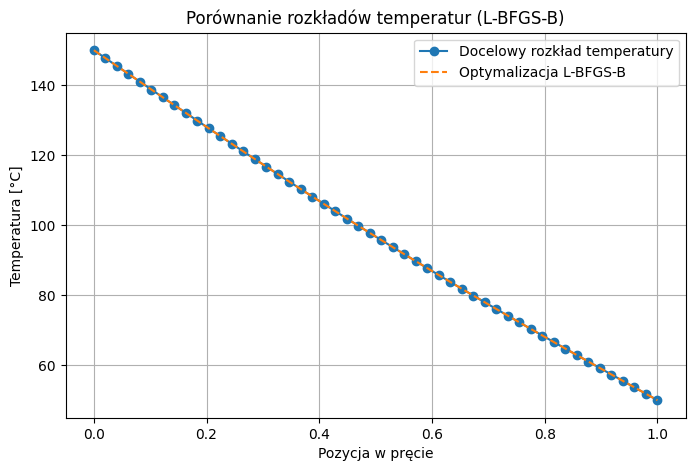


--- Podsumowanie wyników ---
Parametry testowe:
- Liczba węzłów (N): 50
- Przewodność cieplna aluminium (kal): 237.0
- Przewodność cieplna drewna (kw): 0.12
- Temperatura na lewym brzegu (T0): 150
- Temperatura na prawym brzegu (TN): 50
- Tolerancja: 0.01
- Maksymalna liczba iteracji: 10000

Uzyskane warunki brzegowe:
  T_left = 150.0000
  T_right = 50.0000
Czas trwania obliczeń: 32.2194 s


In [21]:
# Generowanie docelowego rozkładu temperatury
T_target = solve_temperature_1D(T0, TN, N)

# Pomiar czasu działania metody L-BFGS-B
start_time = time.time()
optimal_conditions_lbfgsb = optimize_lbfgsb_1D(T_target, N)
end_time = time.time()

# Wyniki
print(f"Optymalne warunki brzegowe (L-BFGS-B): {optimal_conditions_lbfgsb}")
print(f"Czas działania metody L-BFGS-B: {end_time - start_time:.4f} s")

# Wizualizacja wyników
T_optimized = solve_temperature_1D(optimal_conditions_lbfgsb[0], 
                                   optimal_conditions_lbfgsb[1], N)

plt.figure(figsize=(8, 5))
plt.plot(np.linspace(0, 1, N), T_target, '-o', label='Docelowy rozkład temperatury')
plt.plot(np.linspace(0, 1, N), T_optimized, '--', label='Optymalizacja L-BFGS-B')
plt.title('Porównanie rozkładów temperatur (L-BFGS-B)')
plt.xlabel('Pozycja w pręcie')
plt.ylabel('Temperatura [°C]')
plt.grid(True)
plt.legend()
plt.show()

# Dokumentacja wyników
print("\n--- Podsumowanie wyników ---")
print("Parametry testowe:")
print(f"- Liczba węzłów (N): {N}")
print(f"- Przewodność cieplna aluminium (kal): {kal}")
print(f"- Przewodność cieplna drewna (kw): {kw}")
print(f"- Temperatura na lewym brzegu (T0): {T0}")
print(f"- Temperatura na prawym brzegu (TN): {TN}")
print(f"- Tolerancja: {tolerance}")
print(f"- Maksymalna liczba iteracji: {max_iter}")
print("\nUzyskane warunki brzegowe:")
print(f"  T_left = {optimal_conditions_lbfgsb[0]:.4f}")
print(f"  T_right = {optimal_conditions_lbfgsb[1]:.4f}")
print(f"Czas trwania obliczeń: {end_time - start_time:.4f} s")
